In [1]:
%cd "C:/app"

# package pip tensorflow
# github: https://github.com/tensorflow/tensorflow 
# docs: https://www.tensorflow.org/api_docs/python/tf
# examples: https://www.tensorflow.org/

C:\app


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


sns.set(rc={'figure.figsize':(10,5)})
sns.set_theme()
sns.set_style('whitegrid')

**Load Data**

In [4]:
# load data
from sklearn.preprocessing import scale


data = pd.read_csv("./data/rnn/features_targets.csv", index_col="Timestamp", parse_dates=["Timestamp"])
data


excluded_cols = ['Open',
 'High',
 'Low',
 'Close',
 'Symbol']

all_cols = [c for c in data.columns if c not in excluded_cols ]
data = data[all_cols]

data.loc[:, data.columns] = scale(data)

features_cols = data.columns[data.columns.str.contains("TARGET") == False]
features_ = data[features_cols]
features_.info()

target_col = "TARGET_LOGRET_1"
targets_ = data[[target_col]]
targets_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24913 entries, 2021-01-04 00:30:00 to 2022-12-30 22:30:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PCTRET_1  24913 non-null  float64
dtypes: float64(1)
memory usage: 389.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24913 entries, 2021-01-04 00:30:00 to 2022-12-30 22:30:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TARGET_LOGRET_1  24913 non-null  float64
dtypes: float64(1)
memory usage: 389.3 KB


**Create windows**

In [5]:
# create windows
N = 5

features = features_.copy()

f_col = features.columns[0]
features = features_.copy()
for x in range(1, N + 1):
    features[x] = features[f_col].shift(x)
features = features.iloc[N:]

targets = features.pop(f_col)

print(features.info())
print(targets.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24908 entries, 2021-01-04 03:00:00 to 2022-12-30 22:30:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       24908 non-null  float64
 1   2       24908 non-null  float64
 2   3       24908 non-null  float64
 3   4       24908 non-null  float64
 4   5       24908 non-null  float64
dtypes: float64(5)
memory usage: 1.1 MB
None
<class 'pandas.core.series.Series'>
DatetimeIndex: 24908 entries, 2021-01-04 03:00:00 to 2022-12-30 22:30:00
Series name: PCTRET_1
Non-Null Count  Dtype  
--------------  -----  
24908 non-null  float64
dtypes: float64(1)
memory usage: 389.2 KB
None


PCTRET_1
0    12459
1    12449
Name: count, dtype: int64

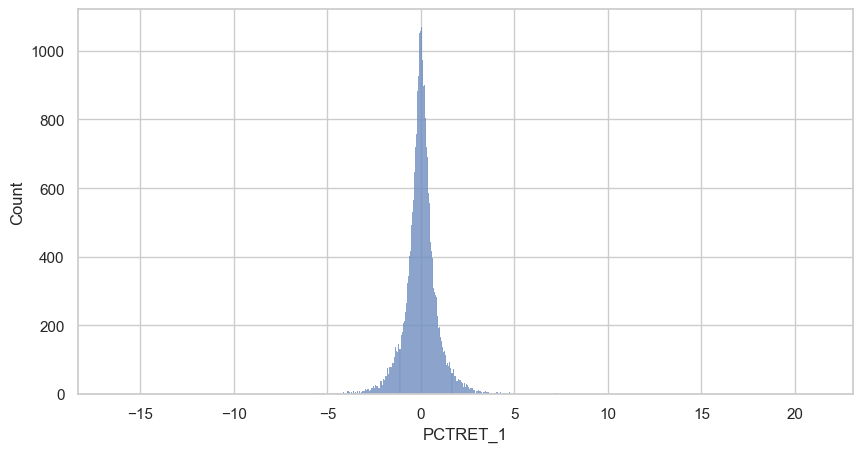

In [6]:
# create label classification
sns.histplot( targets)
targets = (targets > 0).astype(int)
targets.value_counts()

In [7]:
features.columns

Index([1, 2, 3, 4, 5], dtype='object')

In [8]:
# or just this!!!
window_size = features.columns.max()
sequence = list(features.columns)


In [9]:
train_size = 800
test_size = 200

td_features = features.iloc[:train_size]
td_targets = targets.iloc[:train_size]

ted_features = features.iloc[train_size:train_size +  test_size]
ted_targets = targets.iloc[train_size:train_size +  test_size]

td_features.shape
td_targets.shape

(800,)

**Define the Model Architecture**

In [10]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape, BatchNormalization
import tensorflow.keras.backend as K

In [11]:
X_train = td_features.values.reshape(-1, window_size, 1)
y_train = td_targets

X_test = ted_features.values.reshape(-1, window_size, 1)
y_test = ted_targets

In [12]:
K.clear_session() # just to clear clutter that tensorflow makes and release some memory (specifically in for loops model creations)
n_features = 1

input_layer = Input(shape=(window_size, n_features), name="Return")

lstm = LSTM(units=1,  
            input_shape=(window_size, n_features),
            name="LSTM1",
            return_sequences=False
           ) (input_layer)

rnn = Model(inputs=input_layer, outputs=lstm)

rnn.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Return (InputLayer)         [(None, 5, 1)]            0         
                                                                 
 LSTM1 (LSTM)                (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# see the result shape
rnn.predict(X_test).shape

7/7 [==============================] - 1s 4ms/step


(200, 1)

,loss,accuracy,val_loss,val_accuracy
count,86.000000,86.000000,86.000000,86.000000
mean,1.141726,0.502703,0.960300,0.525116
std,0.865225,0.012367,0.547796,0.021543
min,0.693224,0.476250,0.688466,0.495000
25%,0.694010,0.491250,0.689505,0.505000
50%,0.701999,0.506250,0.690373,0.520000
75%,1.046380,0.512500,0.883379,0.540000
max,4.048039,0.521250,3.010970,0.570000


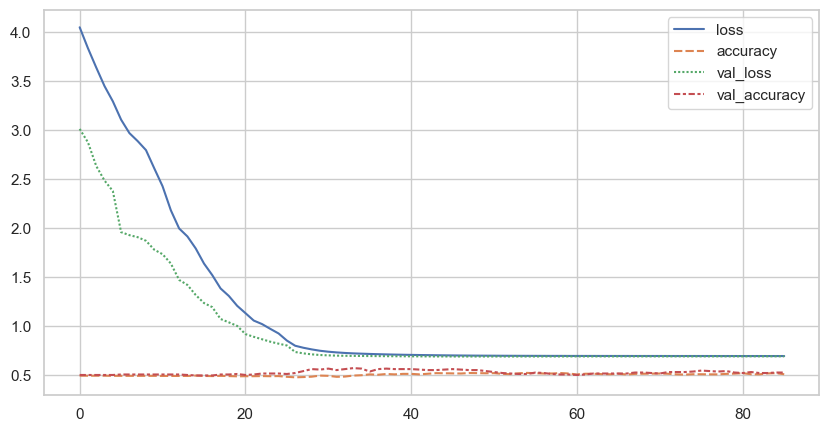

In [14]:
# Train the Model
rnn.compile(loss="binary_crossentropy",
            metrics=["accuracy"])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)

history = rnn.fit(X_train, 
                  y_train,
                  epochs=100,
                  validation_data=(X_test, y_test),
                  callbacks=[early_stop],
                  verbose=0
                 )
sns.lineplot( pd.DataFrame(history.history))
pd.DataFrame(history.history).describe()


In [15]:
# adding dense layer
K.clear_session()
n_features = 1

input_layer = Input(shape=(window_size, n_features), name="Return")

lstm = LSTM(units=3, 
            input_shape=(window_size, n_features),
            name="LSTM1",
            return_sequences=False
           ) (input_layer)

dns = Dense(1, name="output")(lstm)

rnn = Model(inputs=input_layer, outputs=dns)

rnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Return (InputLayer)         [(None, 5, 1)]            0         
                                                                 
 LSTM1 (LSTM)                (None, 3)                 60        
                                                                 
 output (Dense)              (None, 1)                 4         
                                                                 
Total params: 64 (256.00 Byte)
Trainable params: 64 (256.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


,loss,accuracy,val_loss,val_accuracy
count,49.000000,49.000000,49.000000,49.000000
mean,0.838449,0.502347,0.812911,0.494082
std,0.584201,0.011999,0.400612,0.011712
min,0.690553,0.481250,0.693397,0.445000
25%,0.691612,0.496250,0.695341,0.490000
50%,0.692738,0.502500,0.697780,0.495000
75%,0.695842,0.508750,0.707358,0.500000
max,4.436719,0.528750,3.002235,0.515000


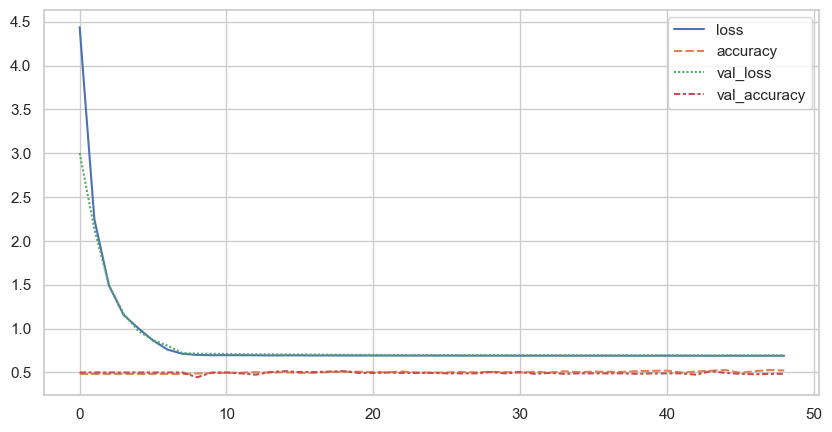

In [16]:
# train
rnn.compile(loss="binary_crossentropy",
            metrics=["accuracy"])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)

history = rnn.fit(X_train, 
                  y_train,
                  epochs=100,
                  validation_data=(X_test, y_test),
                  callbacks=[early_stop],
                  verbose=0
                 )
sns.lineplot( pd.DataFrame(history.history))
pd.DataFrame(history.history).describe()